In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pathlib import Path


root = Path("~/data/ai4animals/sensor_eda/ticc/v6").expanduser()

with (root / "fit/ticc_output.pkl").open("rb") as f:
    cluster, mrfs = pickle.load(f)

cluster.shape, mrfs[0].shape

((13892,), (75, 75))

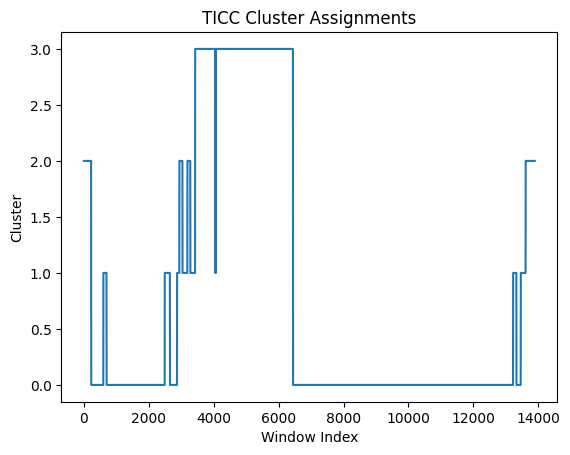

In [35]:
plt.plot(cluster)
plt.title("TICC Cluster Assignments")
plt.xlabel("Window Index")
plt.ylabel("Cluster")
plt.show()

In [36]:
# read in the original data
from collections import Counter

original = pd.read_csv(root / "fit/original_labels.csv")
y = original.behaviourId.values
y.shape, Counter(y)

((13916,),
 Counter({np.int64(0): 11828,
          np.int64(1): 847,
          np.int64(3): 724,
          np.int64(2): 517}))

In [37]:
# create mapping from behaviorId to behavior
behaviour_mapping = original[["behaviourId", "behaviour"]].drop_duplicates().set_index("behaviourId")["behaviour"].to_dict()
behaviour_mapping

{3: 'walking', 1: 'headbutt', 0: 'drinking_milk', 2: 'running'}

In [38]:
y_pred = cluster.flatten()
y_pred.shape, Counter(y_pred)

((13892,),
 Counter({np.float64(0.0): 9300,
          np.float64(3.0): 2990,
          np.float64(1.0): 909,
          np.float64(2.0): 693}))

In [39]:
y_trunc = y[: len(y_pred)]

In [40]:
# count the number of switches in original and prediced
switches = np.sum(y_trunc[1:] != y_trunc[:-1])
total = len(y_trunc)
print(f"Number of switches in original: {switches} out of {total} ({switches/total:.2%})")

switches = np.sum(y_pred[1:] != y_pred[:-1])
total = len(y_pred)
print(f"Number of switches in predicted: {switches} out of {total} ({switches/total:.2%})")

Number of switches in original: 17 out of 13892 (0.12%)
Number of switches in predicted: 18 out of 13892 (0.13%)


In [41]:
# now let's try to match the clusters so we get the best match to the original
from sklearn.metrics import confusion_matrix

# find the best mapping of clusters to original labels

cm = confusion_matrix(y_trunc, y_pred)
cm

array([[8758,   86,    0, 2984],
       [ 102,  279,  436,    6],
       [ 107,  365,   45,    0],
       [ 333,  179,  212,    0]])

In [42]:
# brute force search for the best mapping using the hungarian algorithm
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(-cm)

# predicted to original mapping
mapping = {int(col): int(row) for row, col in zip(row_ind, col_ind)}

row_ind, col_ind, mapping

(array([0, 1, 2, 3]), array([0, 2, 1, 3]), {0: 0, 2: 1, 1: 2, 3: 3})

In [43]:
y_pred_mapped = np.array([mapping[c] for c in y_pred])
y_pred_mapped.shape, Counter(y_pred_mapped)

((13892,),
 Counter({np.int64(0): 9300,
          np.int64(3): 2990,
          np.int64(2): 909,
          np.int64(1): 693}))

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_trunc, y_pred_mapped))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     11828
           1       0.63      0.53      0.58       823
           2       0.40      0.71      0.51       517
           3       0.00      0.00      0.00       724

    accuracy                           0.69     13892
   macro avg       0.49      0.49      0.48     13892
weighted avg       0.85      0.69      0.76     13892



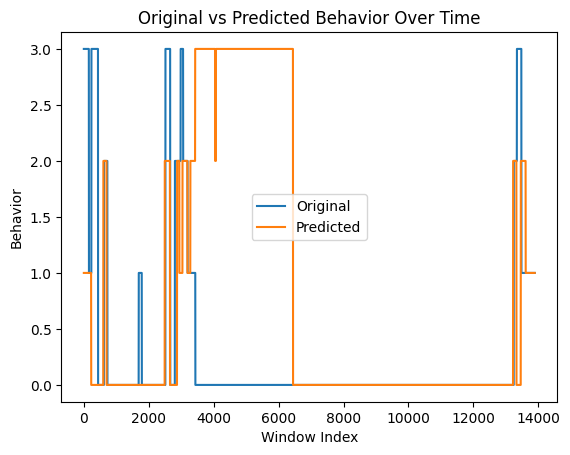

In [45]:
plt.plot(y_trunc, label="Original")
plt.plot(y_pred_mapped, label="Predicted")
plt.legend()
plt.title("Original vs Predicted Behavior Over Time")
plt.xlabel("Window Index")
plt.ylabel("Behavior")
# show the first 1000 only
# plt.xlim(0, 5000)
plt.show()

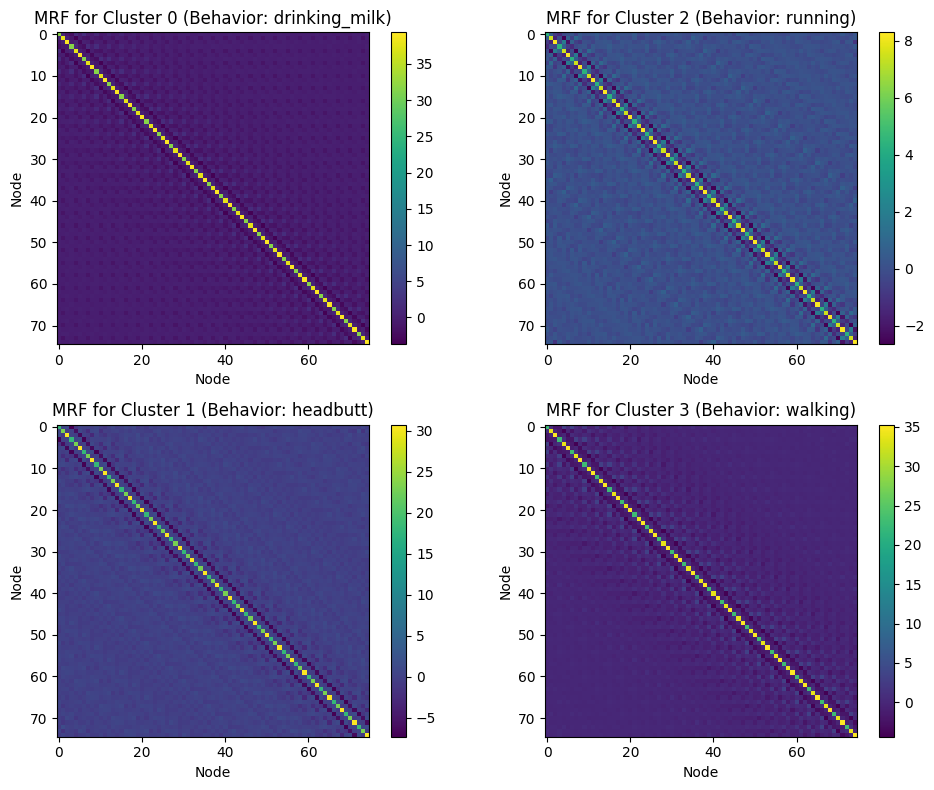

In [46]:
# now lets look at the MRFs and see how we can interpret these
import networkx as nx

# there are 4 clusters, so plot these on the same plot
axes = plt.subplots(2, 2, figsize=(10, 8))[1].flatten()
for i, (ax, mrf) in enumerate(zip(axes, mrfs.values())):
    ax.imshow(mrf)
    j = mapping[i]
    behavior = behaviour_mapping[j]
    ax.set_title(f"MRF for Cluster {j} (Behavior: {behavior})")
    ax.set_xlabel("Node")
    ax.set_ylabel("Node")
    plt.colorbar(mappable=ax.images[0], ax=ax)
plt.tight_layout()
plt.show()

In [51]:
def analyze_mrf(mrf, title="MRF Graph"):
   # convert this to a graph
   data = mrf.copy()
   # set the diagonal to 0
   np.fill_diagonal(data, 0)

   G = nx.from_numpy_array(np.abs(data), create_using=nx.Graph)
   # prune all edges with weight < 1e-8
   G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if abs(d["weight"]) < 1e-3])
   
   # draw the cluster with a spectral layout
   pos = nx.spectral_layout(G)
   nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
   plt.title(title)
   plt.show() 

   # describe summary of G
   print(f"Number of nodes: {G.number_of_nodes()}")
   print(f"Number of edges: {G.number_of_edges()}")

   # use betweenness centrality to find the most important nodes
   betweenness = nx.betweenness_centrality(G, weight="weight")
   # average each of the features
   feature_scores = {0:[], 1:[], 2:[]}
   lag_scores = {i: [] for i in range(25)}
   for node, score in betweenness.items():
      feature = node % 3
      lag = node // 3
      feature_scores[feature].append(score)
      lag_scores[lag].append(score)
   avg_scores = {k: np.mean(v) for k, v in feature_scores.items()}
   avg_lag_scores = {k: np.mean(v) for k, v in lag_scores.items()}
   # treat these as arrays ordered by key
   avg_scores = np.array(list(avg_scores.values()))
   avg_lag_scores = np.array(list(avg_lag_scores.values()))
   print(f"Average betweenness centrality by feature: {avg_scores}")
   print(f"Average betweenness centrality by lag: {avg_lag_scores}")

Cluster 0 (Behavior: drinking_milk)


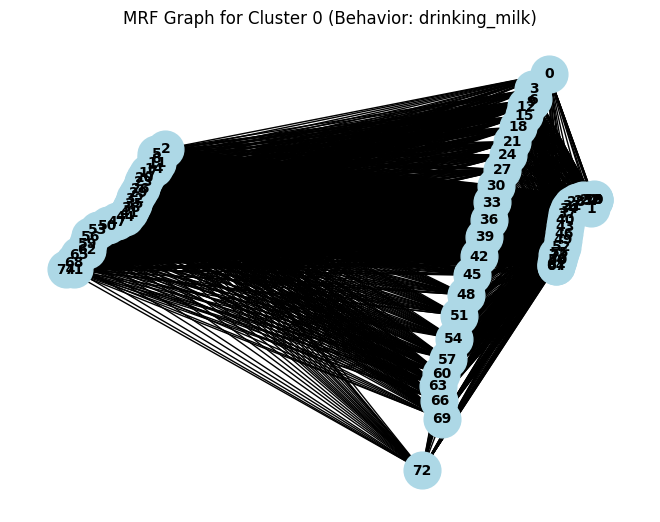

Number of nodes: 75
Number of edges: 2455
Average betweenness centrality by feature: [0.05457238 0.03752684 0.00688634]
Average betweenness centrality by lag: [0.01900531 0.02073306 0.02443539 0.0290016  0.0267802  0.0278909
 0.03813402 0.03196347 0.03023572 0.03467851 0.03949155 0.04270023
 0.04492163 0.05207948 0.04516846 0.04652598 0.04023201 0.04307047
 0.04307047 0.02776749 0.02715044 0.03159324 0.02060965 0.01912872
 0.01851166]
Cluster 2 (Behavior: running)


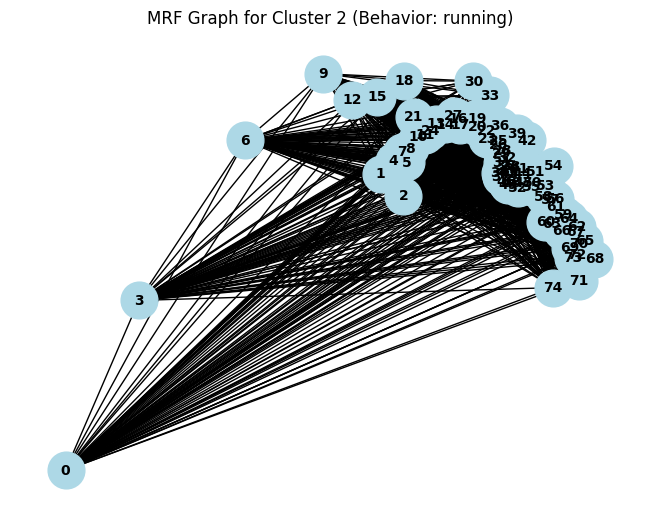

Number of nodes: 75
Number of edges: 2759
Average betweenness centrality by feature: [0.02821177 0.02994447 0.02028878]
Average betweenness centrality by lag: [0.04294706 0.03838085 0.03801061 0.02542268 0.02295446 0.02591633
 0.02023942 0.02036283 0.02258423 0.02246082 0.02369493 0.01530297
 0.00925583 0.01320499 0.02381834 0.02048624 0.02702703 0.02344811
 0.02517586 0.02826114 0.02887819 0.02628656 0.03949155 0.03369123
 0.03640627]
Cluster 1 (Behavior: headbutt)


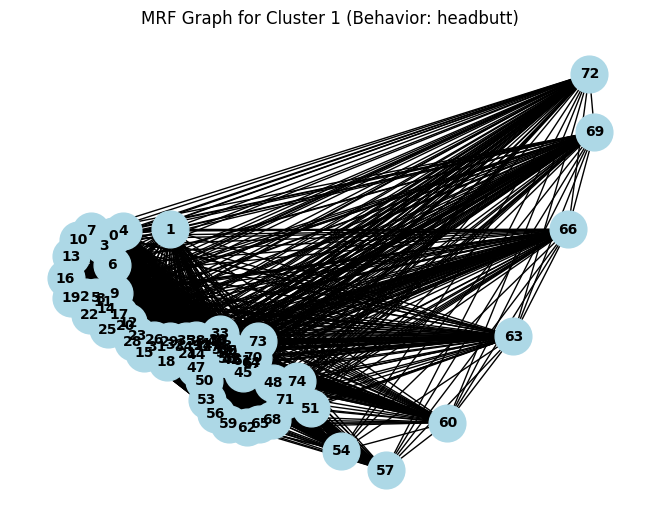

Number of nodes: 75
Number of edges: 2760
Average betweenness centrality by feature: [0.07298038 0.00388004 0.02027397]
Average betweenness centrality by lag: [0.01604344 0.01851166 0.02603974 0.03023572 0.02949525 0.0290016
 0.03295076 0.03072936 0.03739356 0.03628286 0.02838455 0.0378872
 0.04492163 0.04726644 0.04887079 0.03369123 0.03838085 0.0412193
 0.04294706 0.04319388 0.02431198 0.02603974 0.02665679 0.01912872
 0.01986918]
Cluster 3 (Behavior: walking)


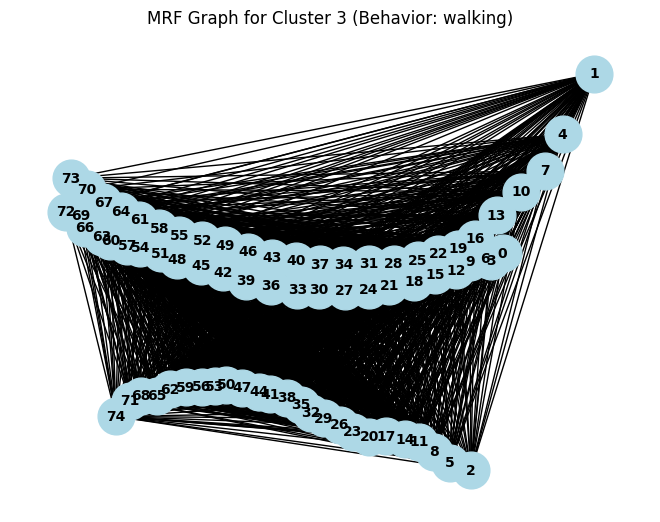

Number of nodes: 75
Number of edges: 2547
Average betweenness centrality by feature: [0.05211403 0.07875602 0.03434284]
Average betweenness centrality by lag: [0.08589411 0.07762557 0.08922621 0.09317537 0.05849685 0.04850056
 0.05553499 0.05479452 0.06022461 0.05862026 0.00703443 0.0088856
 0.00900901 0.0044428  0.00468962 0.05417747 0.06084166 0.05775639
 0.06738245 0.04874738 0.05652228 0.08342589 0.07713193 0.07922991
 0.07540417]


In [52]:
for i, mrf in mrfs.items():
    j = mapping[i]
    behavior = behaviour_mapping[j]
    print(f"Cluster {j} (Behavior: {behavior})")
    analyze_mrf(mrf, title=f"MRF Graph for Cluster {j} (Behavior: {behavior})")